# Определение именованных сущностей в рецептах

* [1] https://open.blogs.nytimes.com/2015/04/09/extracting-structured-data-from-recipes-using-conditional-random-fields
* [2] https://open.blogs.nytimes.com/2016/04/27/structured-ingredients-data-tagging
* [3] https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py
* [4] https://pytorch.org/tutorials/beginner/saving_loading_models.html
* [5] https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
* [6] https://en.wikipedia.org/wiki/Named-entity_recognition

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/wegolev/aspect_recipe_ner.git
# !pip install -r aspect_recipe_ner/requirements.txt
# import sys; sys.path.append('./aspect_recipe_ner')

In [2]:
# Для выполнения этого задания не забудьте установить:
# !pip install spacy_udpipe
# !pip install ipymarkup
# !pip install livelossplot
# !pip list

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd

In [5]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./aspect_recipe_ner/
df = pd.read_csv('datasets/nyt-ingredients-head.csv')

In [6]:
df[0:5]

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN


## Аннотированные (BIO) рецепты

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [9]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./aspect_recipe_ner/
datafile = 'datasets/BIO_recipe_dataset.txt'
lines    = open(datafile, encoding='utf-8').read().strip().split('\n')

#### словарь и тэги:

In [10]:
from dlnlputils.recipe_utils import form_vocabulary_and_tagset, prepare_data, show_markup, Converter, tag_statistics, plot_confusion_matrix, recipe_statistics, plot_recipe_statistics

In [11]:
vocabulary,labels = form_vocabulary_and_tagset(lines)

In [17]:
print(type(vocabulary))
print(len(vocabulary))
print(vocabulary)

<class 'set'>
5194
{'1-3/4', 'multicolored', 'mixture', '8-by-8', 'ice', 'broccoflower', 'globe', 'other', 'cheesecloth', 'Monterey', 'Extra', 'Stewed', 'mellow', 'basil', 'chaat', 'raisin-pumpernickel', 'pike', 'Thyme', "d'Acqui", 'thin-skinned', 'purpose', 'shank-half', 'through', '/2', 'low-sodium', 'orange-flesh', 'meringue', 'those', 'Round', 'jerk', 'cod', 'lettuces', 'Cortland', 'buttercup', 'Poire', 'hazelnut', 'neither', 'brushed', 'veal', 'muscat', 'gris', 'than', 'lentils', 'href="http://cooking.nytimes.com/recipes/1533-zucchini-cake-mousse-gateau-de-courgettes">see', 'along', 'gnocchetti', 'unsulfured', 'citron', 'oxtail', 'Noor', 'milliliters', 'patties', '1/4-inch-round', 'bunch', 'Rosa', '24$1/2-inch', 'Approximately', 'Crushed', 'habichuelas', 'seared', 'Barbados', 'caul', 'blossom', 'anglaise', 'wrapped', 'anisette', 'Wondra', 'of', 'week;', 'seconds', 'href="http://cooking.nytimes.com/recipes/4573-sofrito">see', 'red-dyed', 'skim', 'firm-fleshed', 'stacked', 'head-on'

In [15]:
print(type(labels))
print(len(labels))
print(labels)

<class 'set'>
10
{'B-COMMENT', 'I-NAME', 'B-RANGE_END', 'OTHER', 'B-UNIT', 'B-QTY', 'B-INDEX', 'I-UNIT', 'I-COMMENT', 'B-NAME'}


#### рецепты:

In [19]:
recipes_w_tags = prepare_data(lines)

len(recipes_w_tags)

49847

In [22]:
test_recipe, test_tags = recipes_w_tags[0]
print(test_recipe)
print(test_tags)

['1$1/4', 'cups', 'cooked', 'and', 'pureed', 'fresh', 'butternut', 'squash', ',', 'or', '1', '10-ounce', 'package', 'frozen', 'squash', ',', 'defrosted']
['B-QTY', 'B-UNIT', 'B-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'B-NAME', 'I-NAME', 'OTHER', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'B-NAME', 'OTHER', 'I-COMMENT']


In [12]:
show_markup(test_recipe, test_tags)

In [13]:
for i in range(5):
  test_recipe, test_tags = recipes_w_tags[i]
  show_markup(test_recipe, test_tags)

#### перевод слов и тэгов в индексы - и обратно:

In [14]:
converter = Converter(vocabulary,labels)

In [15]:
test_recipe, test_tags = recipes_w_tags[0]


encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()


decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags)

tensor([  57, 2245, 2133, 1520, 4060, 2650, 1846, 4624,   25, 3729,   42,  125,
        3771, 2668, 4624,   25, 2303])
tensor([3, 5, 0, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



In [16]:
training_data = recipes_w_tags[     :40000]
test_data     = recipes_w_tags[40000:]

## LSTM

In [17]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

In [18]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):

        super(LSTMTagger, self).__init__()

        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)

        return tag_scores

    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)

        return tags_pred

In [19]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss()
optimizer     = optim.SGD(model.parameters(), lr=0.1)

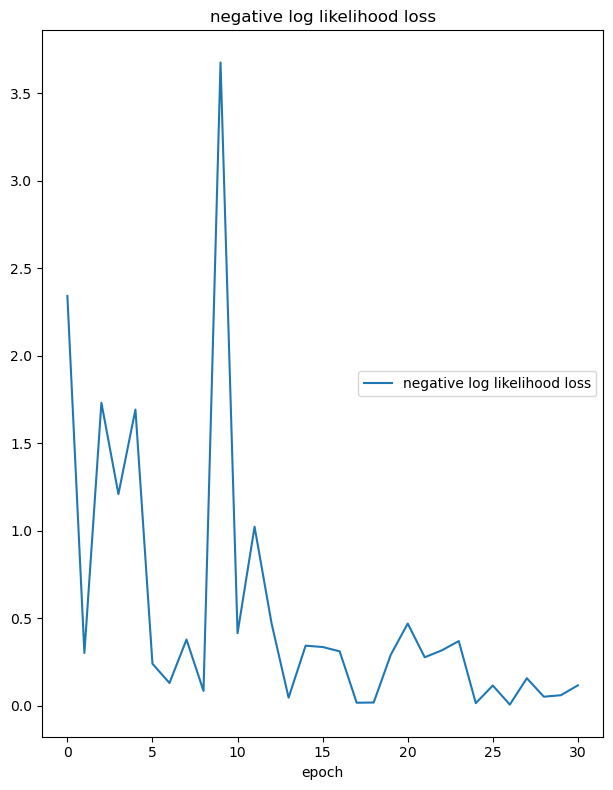

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.007, max:    3.676, cur:    0.117)


In [20]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(1):
    for i, (recipe, tags) in enumerate(training_data):

        model.zero_grad()

        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов

        tag_scores     = model(encoded_recipe)

        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()


        if i % 500 == 0:
            # liveplot.update({'negative log likelihood loss': loss}) # RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
            liveplot.update({'negative log likelihood loss': loss.detach()})
            liveplot.draw()



        if i == 15000:
            break

In [21]:
def predict_tags(model, converter, recipe):

    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре

    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг

    return decoded_tags

In [22]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,7000)]

    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    show_markup(recipe, tags)

    print('предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Save & Load model

In [ ]:
'''
torch.save(model.state_dict(), 'models/recipe.pt')
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

model.load_state_dict(torch.load('models/recipe.pt'))
model.eval()


recipe, tags = test_data[4444]

tags_pred = predict_tags(model, recipe)

print('ground truth:')
print(list(zip(recipe, tags)))
print()

print('prediction:')
print(list(zip(recipe, tags_pred)))


print('ground truth:')
show_markup(recipe, tags)

print('prediction:')
show_markup(recipe, tags_pred)
'''
print()

: 

## Проверка возможностей нейросети на тестовых данных:

### Количество верно предсказанных тэгов:

In [23]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для B-QTY:
  корректно:	 8266
      всего:	 8420
% корректно:	 98.1710213776722

для B-COMMENT:
  корректно:	 5366
      всего:	 7823
% корректно:	 68.59261153010354

для B-RANGE_END:
  корректно:	 113
      всего:	 156
% корректно:	 72.43589743589743

для B-UNIT:
  корректно:	 6787
      всего:	 7074
% корректно:	 95.94288945433985

для B-NAME:
  корректно:	 8728
      всего:	 10278
% корректно:	 84.91924498929752

для I-NAME:
  корректно:	 4336
      всего:	 5528
% корректно:	 78.43704775687411

для I-COMMENT:
  корректно:	 13713
      всего:	 14984
% корректно:	 91.51761879337961

для OTHER:
  корректно:	 1964
      всего:	 4101
% корректно:	 47.89075835162156

----------
в итоге:
  корректно:	 49273
      всего:	 58364
% корректно:	 84.42361729833459


### Матрица Ошибок (Confusion Matrix)

In [24]:
y_pred = []
y_true = []

for recipe, tags in test_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags

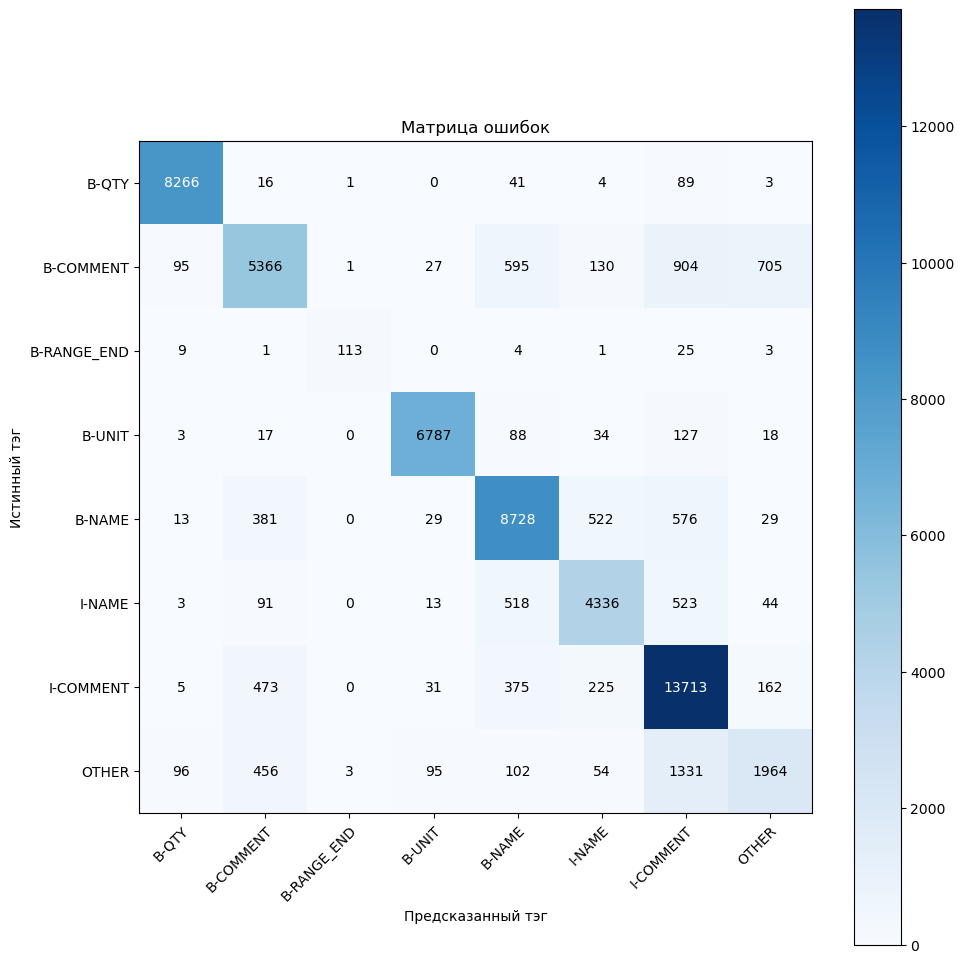

In [25]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

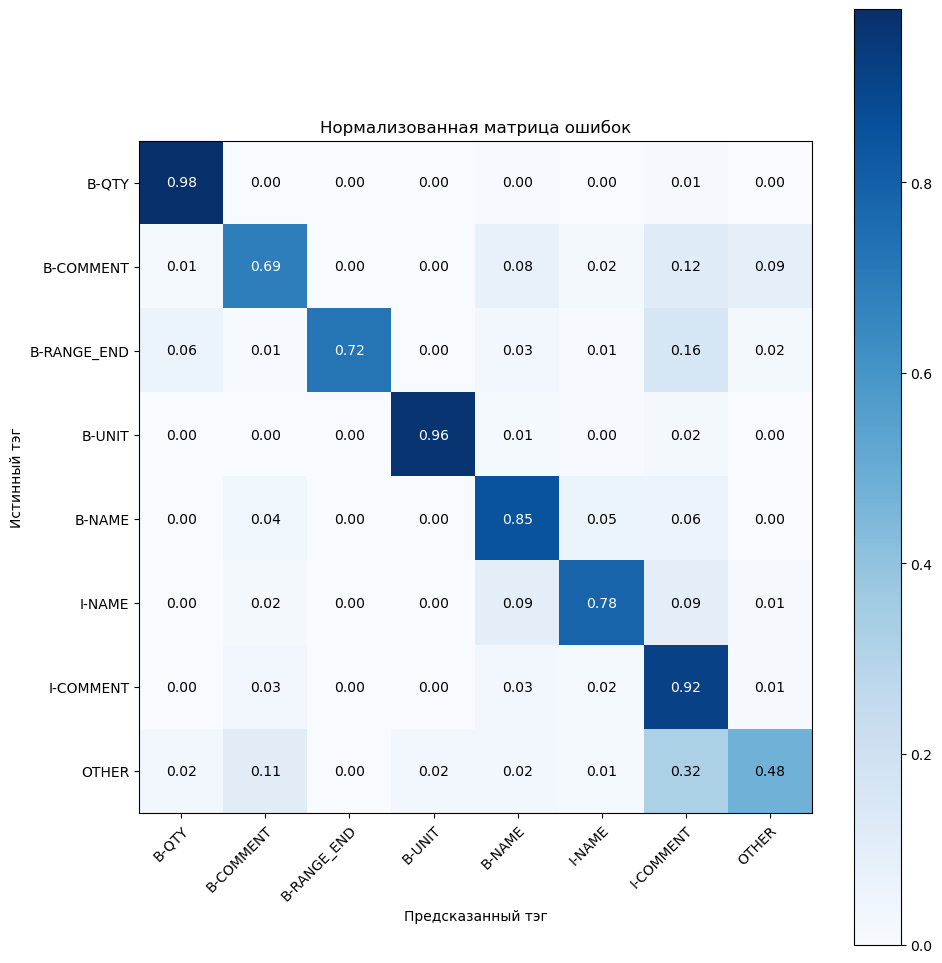

In [26]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True,
                      title='Нормализованная матрица ошибок')

plt.show()

### Количество верно размеченных рецептов:

In [27]:
correct_recipes, total_recipes = recipe_statistics(model, converter, test_data, 4)

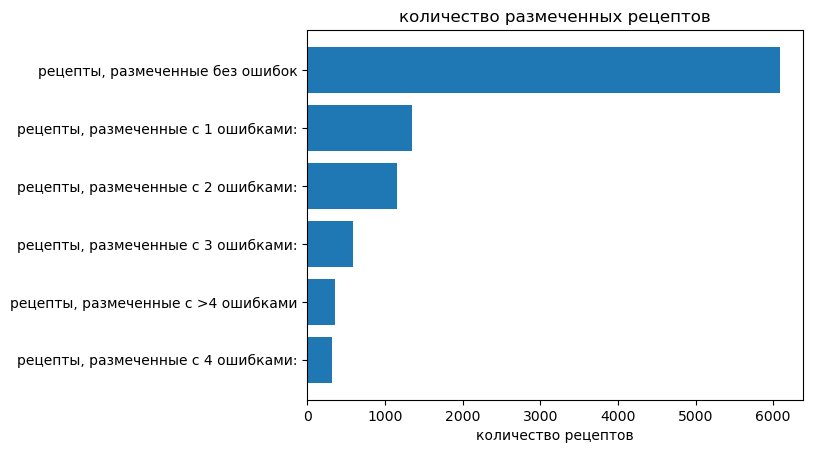

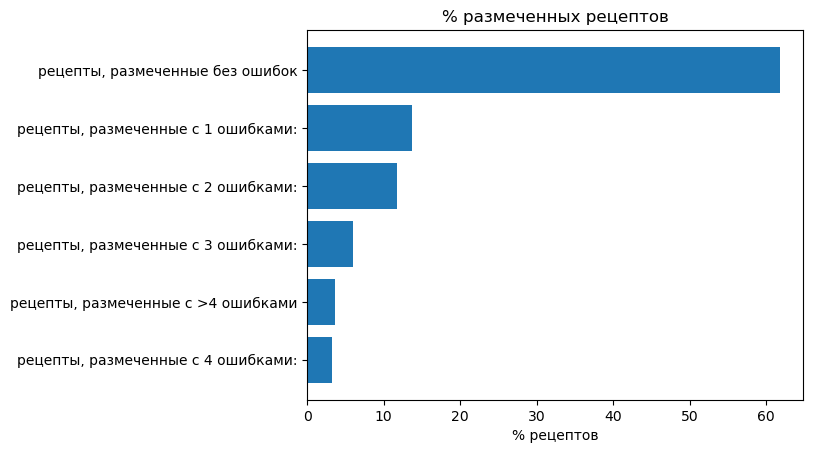

In [28]:
plot_recipe_statistics(correct_recipes)
plot_recipe_statistics(correct_recipes, total_recipes)